In [ ]:
# Implementation of "Lightweight Probabilistic Deep Networks"
#  https://arxiv.org/pdf/1805.11327.pdf

# Create data based on some simple function
# Create a model (keras) that can be trained
# Run predictions
# Add different levels noise to the input features
#  - Remember the level of uncertainty for each example and feature



In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
def datagen(x):
    return 0.05 * np.power(x, 3.0) + 0.5

0.997666705899


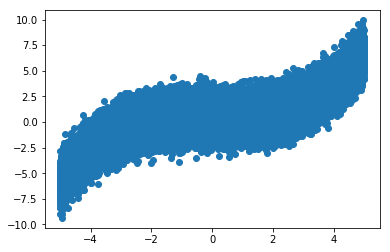

In [45]:
np.random.seed(666)

nrofExamples = 100000
input_var = 1.0
e = np.random.randn(nrofExamples, 1) * np.sqrt(input_var)
X = np.random.uniform(low=-5.0, high=5.0, size=(nrofExamples,1))
y = datagen(X) + e
xv = np.ones((nrofExamples, 1)) * input_var
print(np.std(e)**2)

plt.scatter(X,y)

In [34]:
def relu(mu_in, var_in):
    dist = tf.distributions.Normal(loc=0.0, scale=1.0)
    sigma = tf.sqrt(var_in)
    pdf = dist.prob(mu_in / tf.sqrt(var_in))
    cdf = dist.cdf(mu_in / tf.sqrt(var_in))
    
    mu_relu = mu_in * cdf + sigma * pdf
    var_relu = (mu_in + var_in) * cdf + mu_in*sigma*pdf + tf.pow(mu_relu, 2)
    
    return mu_relu, var_relu

def prob_dense(sz, mu_in, var_in, use_relu=False):
    d = int(mu_in.get_shape()[1])
    W = tf.Variable(tf.random_normal((d, sz)), dtype=tf.float32)
    b = tf.Variable(tf.random_normal((sz,)), dtype=tf.float32)
    mu_dense = tf.nn.relu(tf.matmul(mu_in, W) + b)
    sq = tf.transpose(W**2)
    var_dense = var_in @ tf.matrix_transpose(sq)
    #print((var_in.shape.as_list(), sq.shape.as_list(), var_out.shape.as_list()))
    if use_relu:
        mu_relu, var_relu = relu(mu_dense, var_dense)
    else:
        mu_relu, var_relu = (mu_dense, var_dense)
    return mu_relu, var_relu

def probnet(mu_in, var_in):
    mu1, var1 = prob_dense(20, mu_in, var_in, use_relu=True)
    mu2, var2 = prob_dense(20, mu1, var1, use_relu=True)
    mu3, var3 = prob_dense(20, mu2, var2, use_relu=True)
    mu4, var4 = prob_dense(20, mu3, var3, use_relu=True)
    mu_out, var_out = prob_dense(1, mu4, var4)
    return mu_out, var_out

def prob_loss(y_mu, y_var, y_true):
    loss = tf.reduce_sum((y_true-y_mu)**2 / y_var + tf.log(y_var))
    return loss

In [63]:
batch_size = 32
learning_rate = 0.0005
nrof_epochs = 4
show_every = 100
    
sess = tf.Session()

# Create a dataset tensor from the images and the labels
nrof_batches_per_epoch = int(np.ceil(X.shape[0] / batch_size))
dataset = tf.data.Dataset.from_tensor_slices((X.astype(np.float32), xv.astype(np.float32), y.astype(np.float32)))

# Automatically refill the data queue when empty
dataset = dataset.repeat()
# Create batches of data
dataset = dataset.batch(batch_size)
# Prefetch data for faster consumption
#dataset = dataset.prefetch(batch_size)

# Create an iterator over the dataset
iterator = dataset.make_initializable_iterator()
# Initialize the iterator
sess.run(iterator.initializer)

# Neural Net Input (images, labels)
x_mu_batch, x_var_batch, y_true_batch = iterator.get_next()

y_mu, y_var = probnet(x_mu_batch, x_var_batch)

loss = prob_loss(y_mu, y_var, y_true_batch)
#print(loss)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)

# Initialize the variables (i.e. assign their default value)
sess.run(tf.global_variables_initializer())

# Training cycle
for epoch in range(1, nrof_epochs+1):
    loss_list = []
    y_mu_list = []
    y_var_list = []
    y_true_list = []
    for step in range(1, nrof_batches_per_epoch+1):
        _, loss_, y_mu_, y_var_, y_true_  = sess.run([train_op, loss, y_mu, y_var, y_true_batch])
        loss_list.append(loss_)
        y_mu_list.append(y_mu_)
        y_var_list.append(y_var_)
        y_true_list.append(y_true_)
        
        if step % show_every==0 or step==nrof_batches_per_epoch:
            y_mu_arr = np.concatenate(y_mu_list)
            y_var_arr = np.concatenate(y_var_list)
            y_true_arr = np.concatenate(y_true_list)
            var_est = np.std(y_mu_arr-y_true_arr)**2
            var_mean = np.mean(y_var_arr)
            print('Epoch: %4d  Step: %4d  Avg loss: %.3f  varEst: %.3f  varMean: %.3f' % (epoch, step, np.mean(loss_list), var_est, var_mean))
            loss_list = []
            y_mu_list = []
            y_var_list = []
            y_true_list = []

print('Done!')


Epoch:    1  Step:  100  Avg loss: 428.119  varEst: 6.451  varMean: 970109.625
Epoch:    1  Step:  200  Avg loss: 406.646  varEst: 6.703  varMean: 496334.531
Epoch:    1  Step:  300  Avg loss: 385.340  varEst: 6.497  varMean: 257379.062
Epoch:    1  Step:  400  Avg loss: 364.296  varEst: 6.512  varMean: 129300.102
Epoch:    1  Step:  500  Avg loss: 342.170  varEst: 6.572  varMean: 64199.078
Epoch:    1  Step:  600  Avg loss: 322.270  varEst: 6.595  varMean: 34552.250
Epoch:    1  Step:  700  Avg loss: 301.401  varEst: 6.451  varMean: 17979.689
Epoch:    1  Step:  800  Avg loss: 279.744  varEst: 6.488  varMean: 9245.878
Epoch:    1  Step:  900  Avg loss: 256.420  varEst: 6.642  varMean: 4574.238
Epoch:    1  Step: 1000  Avg loss: 232.094  varEst: 6.615  varMean: 2152.675
Epoch:    1  Step: 1100  Avg loss: 206.070  varEst: 6.114  varMean: 973.603
Epoch:    1  Step: 1200  Avg loss: 179.567  varEst: 6.250  varMean: 434.551
Epoch:    1  Step: 1300  Avg loss: 152.152  varEst: 6.425  varMean:

Epoch:    4  Step: 1700  Avg loss: 70.407  varEst: 6.627  varMean: 6.890
Epoch:    4  Step: 1800  Avg loss: 68.881  varEst: 6.593  varMean: 6.661
Epoch:    4  Step: 1900  Avg loss: 69.624  varEst: 6.469  varMean: 6.690
Epoch:    4  Step: 2000  Avg loss: 69.789  varEst: 6.607  varMean: 6.967
Epoch:    4  Step: 2100  Avg loss: 70.749  varEst: 7.016  varMean: 6.994
Epoch:    4  Step: 2200  Avg loss: 68.807  varEst: 6.530  varMean: 6.619
Epoch:    4  Step: 2300  Avg loss: 68.298  varEst: 6.312  varMean: 6.523
Epoch:    4  Step: 2400  Avg loss: 68.727  varEst: 6.425  varMean: 6.634
Epoch:    4  Step: 2500  Avg loss: 69.446  varEst: 6.473  varMean: 6.609
Epoch:    4  Step: 2600  Avg loss: 68.763  varEst: 6.394  varMean: 6.604
Epoch:    4  Step: 2700  Avg loss: 69.638  varEst: 6.502  varMean: 6.610
Epoch:    4  Step: 2800  Avg loss: 70.039  varEst: 6.628  varMean: 6.806
Epoch:    4  Step: 2900  Avg loss: 68.260  varEst: 6.547  varMean: 6.617
Epoch:    4  Step: 3000  Avg loss: 71.850  varEst: 

In [ ]:
mu_test = np.arange(-7.0, 7.0, 0.01)
var_test = np.ones_like(mu_test) * 
y_test = datagen(x_test)

val_set = tf.data.Dataset.from_tensor_slices((x_test.astype(np.float32), xv.astype(np.float32), y_test.astype(np.float32)))

# Automatically refill the data queue when empty
dataset = dataset.repeat()
# Create batches of data
dataset = dataset.batch(batch_size)
# Prefetch data for faster consumption
#dataset = dataset.prefetch(batch_size)

# Create an iterator over the dataset
iterator = dataset.make_initializable_iterator()
# Initialize the iterator
sess.run(iterator.initializer)


In [ ]:
x_test = np.arange(-7.0, 7.0, 0.01)
y_test_hat = model.predict([x_test)

y_test = datagen(x_test)
plt.scatter(x_test, y_test_hat, s=3)
plt.plot(x_test, y_test, 'r-')